In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

In [114]:
data = pd.read_csv('Data/train.csv')
X, y = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1), data.iloc[:, 0].values
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)
y = tf.keras.utils.to_categorical(y)

In [115]:
X = X / 255
X_test = X_test / 255

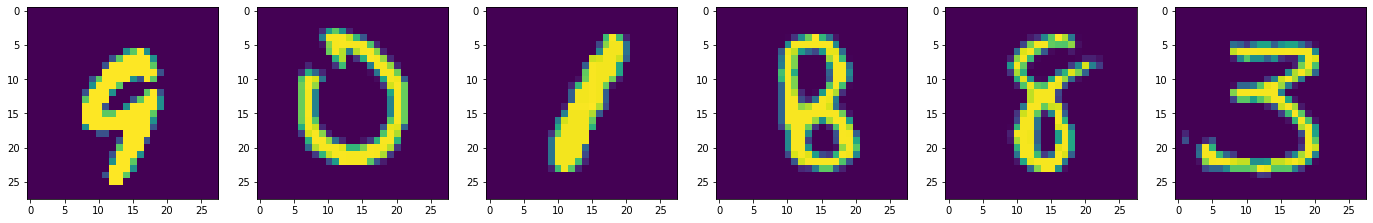

In [116]:
fig, ax = plt.subplots(figsize=(24, 6), ncols=6)

for i in range(6):
    ax[i].imshow(X[randint(0, X.shape[0])])

In [98]:
def get_model():

    data_augmentation = Sequential(
        [
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ]
    )
    
    input_layer = layers.Input(shape=(28, 28, 1))
    data_aug = data_augmentation(input_layer)
    layer_1 = layers.Conv2D(32, kernel_size=3, activation='relu')(data_aug)
    layer_3 = layers.MaxPooling2D(pool_size=(2, 2))(layer_1)

    layer_4 = layers.Conv2D(64, kernel_size=3, activation='relu')(layer_3)
    layer_6 = layers.MaxPooling2D(pool_size=(2, 2))(layer_4)

    layer_7 = layers.Conv2D(128, kernel_size=3, activation='relu')(layer_6)
    layer_9 = layers.MaxPooling2D(pool_size=(2, 2))(layer_7)

    layer_10 = layers.Dropout(0.2)(layer_9)
    layer_11 = layers.Flatten()(layer_10)
    layer_12 = layers.Dense(100, activation='relu')(layer_11)
    layer_13 = layers.Dense(10, activation='sigmoid')(layer_12)

    model = Model(inputs=input_layer, outputs=layer_13)

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [99]:
model = get_model()

In [100]:
model.fit(
    x=X,
    y=y,
    validation_split=0.05,
    batch_size=256,
    epochs=50
)

Epoch 1/50
141/141 [==============================] - 3s 15ms/step - loss: 0.2824 - accuracy: 0.3802 - val_loss: 0.0923 - val_accuracy: 0.8593
Epoch 2/50
141/141 [==============================] - 2s 15ms/step - loss: 0.0921 - accuracy: 0.8470 - val_loss: 0.0415 - val_accuracy: 0.9328
Epoch 3/50
141/141 [==============================] - 2s 15ms/step - loss: 0.0564 - accuracy: 0.9103 - val_loss: 0.0289 - val_accuracy: 0.9566
Epoch 4/50
141/141 [==============================] - 2s 12ms/step - loss: 0.0441 - accuracy: 0.9294 - val_loss: 0.0235 - val_accuracy: 0.9661
Epoch 5/50
141/141 [==============================] - 2s 15ms/step - loss: 0.0370 - accuracy: 0.9400 - val_loss: 0.0212 - val_accuracy: 0.9677
Epoch 6/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0322 - accuracy: 0.9491 - val_loss: 0.0193 - val_accuracy: 0.9725
Epoch 7/50
141/141 [==============================] - 2s 12ms/step - loss: 0.0300 - accuracy: 0.9518 - val_loss: 0.0187 - val_accuracy: 0.9709

### Using XGBoost Classifier as Top Level Model

In [117]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [118]:
xgb = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', use_label_encoder=False, eval_metric='mlogloss')
feature_extraction_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [119]:
def train_xgb(feature_extraction_model: Model, xgb: XGBClassifier, X: np.ndarray, y: np.ndarray) -> XGBClassifier:
    nn_output = feature_extraction_model.predict(X)
    y = np.argmax(y, axis=1)
    xgb = xgb.fit(nn_output, y)
    return xgb

def predict_xgb(feature_extraction_model, xgb, X):
    nn_output = feature_extraction_model.predict(X)
    preds = xgb.predict(nn_output)
    return preds
    

In [120]:
xgb = train_xgb(feature_extraction_model, xgb, X, y)

In [125]:
ensemble_preds = predict_xgb(feature_extraction_model, xgb, X_test)
nn_preds = model.predict(X_test)

In [129]:
accuracy_score(y_test, nn_preds.argmax(axis=1))

0.9916666666666667

In [126]:
accuracy_score(y_test, ensemble_preds)

0.9921428571428571